In [ ]:
%pip install coremltools
%pip install timm
%pip install opencv-python
%pip install thop
%pip install pandas
%pip install seaborn

In [6]:
import torch

config = {
    'classical_sr' : {
        'args': {
            'upscale' : 2, # flexible
            'in_chans' : 3,
            'img_size' : 48,
            'window_size' : 8,
            'img_range' : 1.,
            'depths' :[6, 6, 6, 6, 6, 6],
            'embed_dim' : 180,
            'num_heads' : [6, 6, 6, 6, 6, 6],
            'mlp_ratio' : 2,
            'upsampler' : 'pixelshuffle',
            'resi_connection' : '1conv',
        },
        'path' : 'model_zoo/swinir/001_classicalSR_DIV2K_s48w8_SwinIR-M_x2.pth', #match with upscale factor
    },
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',

    'lightweight_sr' : {
        'args': {
            'upscale' : 2, # flexible
            'in_chans' : 3,
            'img_size' : 64,
            'window_size' : 8,
            'img_range' : 1.,
            'depths' :[6, 6, 6, 6],
            'embed_dim' : 60,
            'num_heads' : [6, 6, 6, 6],
            'mlp_ratio' : 2,
            'upsampler' : 'pixelshuffledirect',
            'resi_connection' : '1conv',
        },
        'path' : 'model_zoo/swinir/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x2.pth', #match with upscale factor
    }
}

In [ ]:
from models.network_swinir import SwinIR as net

device = config['device']
TASK_NAME = 'lightweight_sr'


model_info = config[TASK_NAME]
model = net(**model_info['args'])
param_key_g = 'params'

pretrained_model = torch.load(model_info['path'])
model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)
model.to(device)

In [104]:
import importlib
from torch.nn.utils.prune import global_unstructured, L1Unstructured
import copy
import pruning_utils as pu
importlib.reload(pu)
mod2prune = copy.deepcopy(model)

parameters_to_prune = [
    (module, name) for module in mod2prune.modules()
    for name, param in module.named_parameters(recurse=False)
]

orig_params = copy.deepcopy(parameters_to_prune)
n_iter = 5
for itr in range(n_iter):
    global_unstructured(
        parameters_to_prune,
        pruning_method=L1Unstructured,
        amount=0.33
    )

print(f'\noverall sparsity: {pu.calculate_sparsity_overall(mod2prune, parameters_to_prune):.4f}')
print(f'model size: {pu.calculate_sparse_model_size(mod2prune, temp_file=f"pruned_models/unstructured_itr_{n_iter}.pt"):.2f} MB')


overall sparsity: 0.8650
model sparsity: 0.8510
model size: 16.41 MB


In [85]:
print(f'model size: {pu.calculate_sparse_model_size(model):.2f} MB')

model sparsity: 0.0000
model size: 34.07 MB


In [ ]:
pruning_data_unstructured = {
    "Iteration" : [0, 1, 2, 3, 4, 5],
    "Sparsity" : [0.0, 0.33, 0.5511, 0.6992, 0.7985, 0.8650],
    "Accuracy" : [],
    "Latency (s)" : [],
    "Disk Size (MB)" : [34.07, 27.23, 22.52, 19.56, 17.65, 16.40],
}

## Structured pruning

### Pruning Attention Heads
Each qkv module has `dim=60` and 6 heads. The qkv projections are done in a single `nn.Linear(in_features=60, out_features=180, bias=True)`. The weights, shaped as `(out_features, in_features)`, are reshaped to `(3, num_heads, head_dim, in_features) = (3, 6, 10, 60)`. We prune each head across q, k, v using `weights[:, head, :, :] = 0`.  

Per head pruned, we remove `3 * 10 * 60 = 1800` parameters per layer.  
With 24 window attention modules in the model, we prune `1800 * 24 = 43200` parameters per head.

pruning: 0 heads


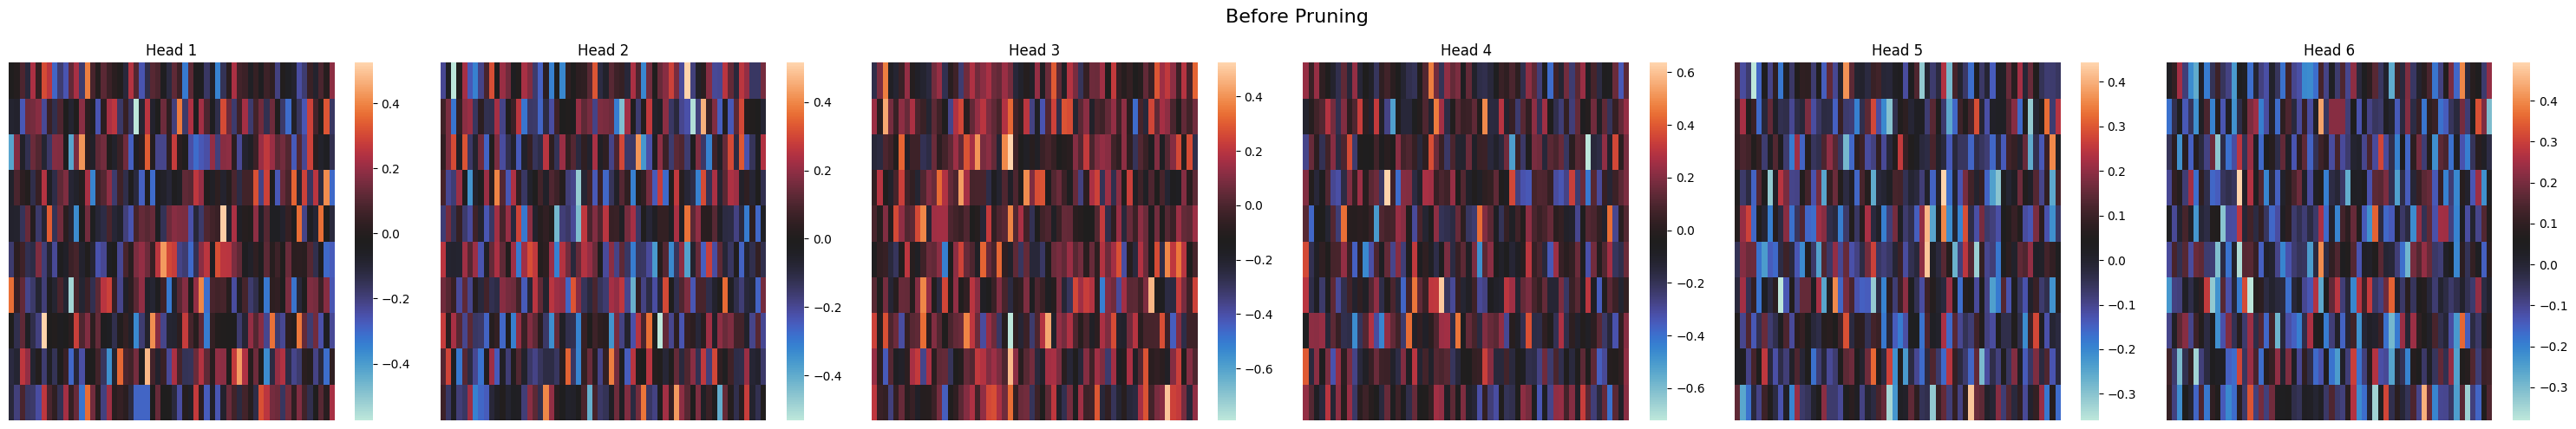

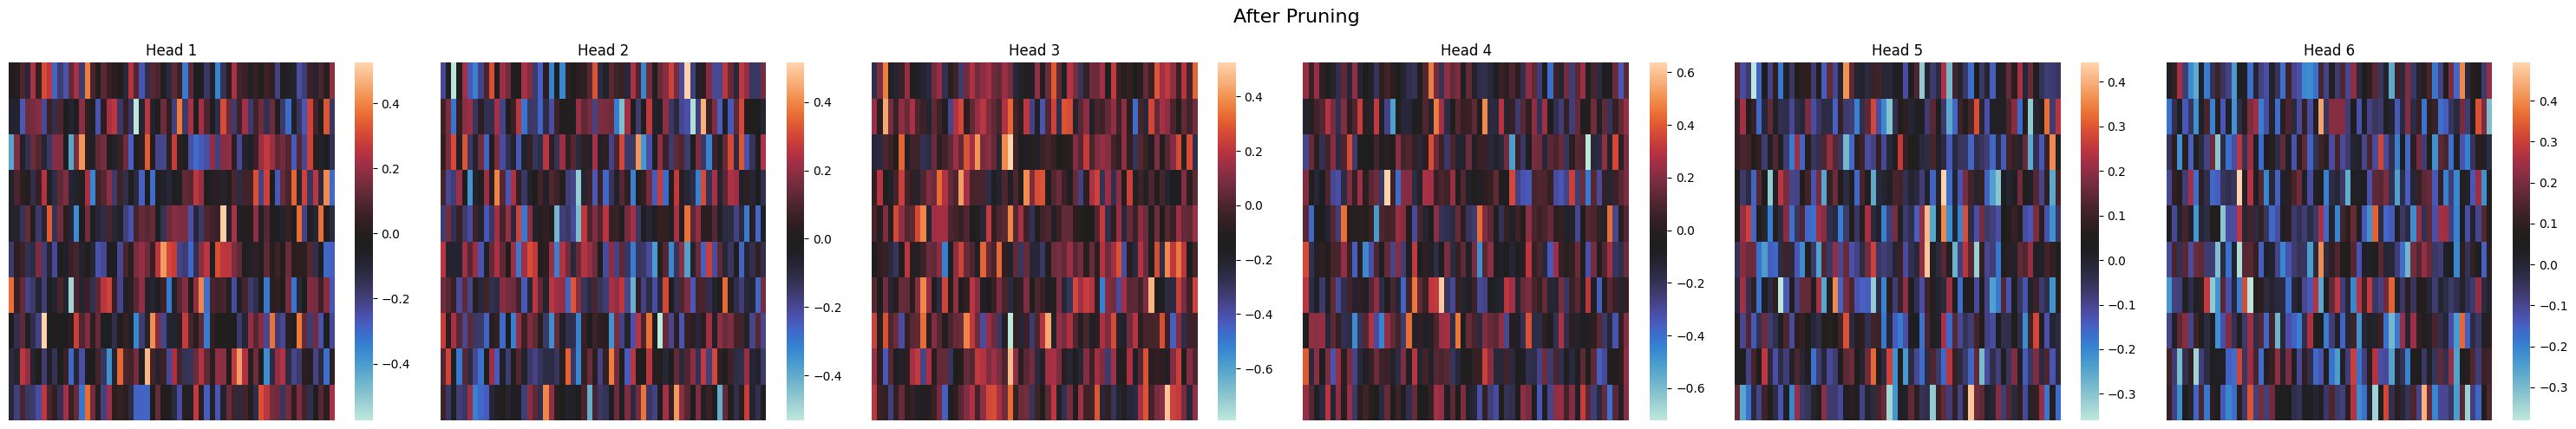

total params pruned: 0 across 24 layers
Overall sparsity: 0.0000
calculating model sparsity with 910,152 non-zero params out of 910,152 total params
model sparsity: 0.0000
sparse model size: 34.0811
------------------------------
pruning: 1 heads


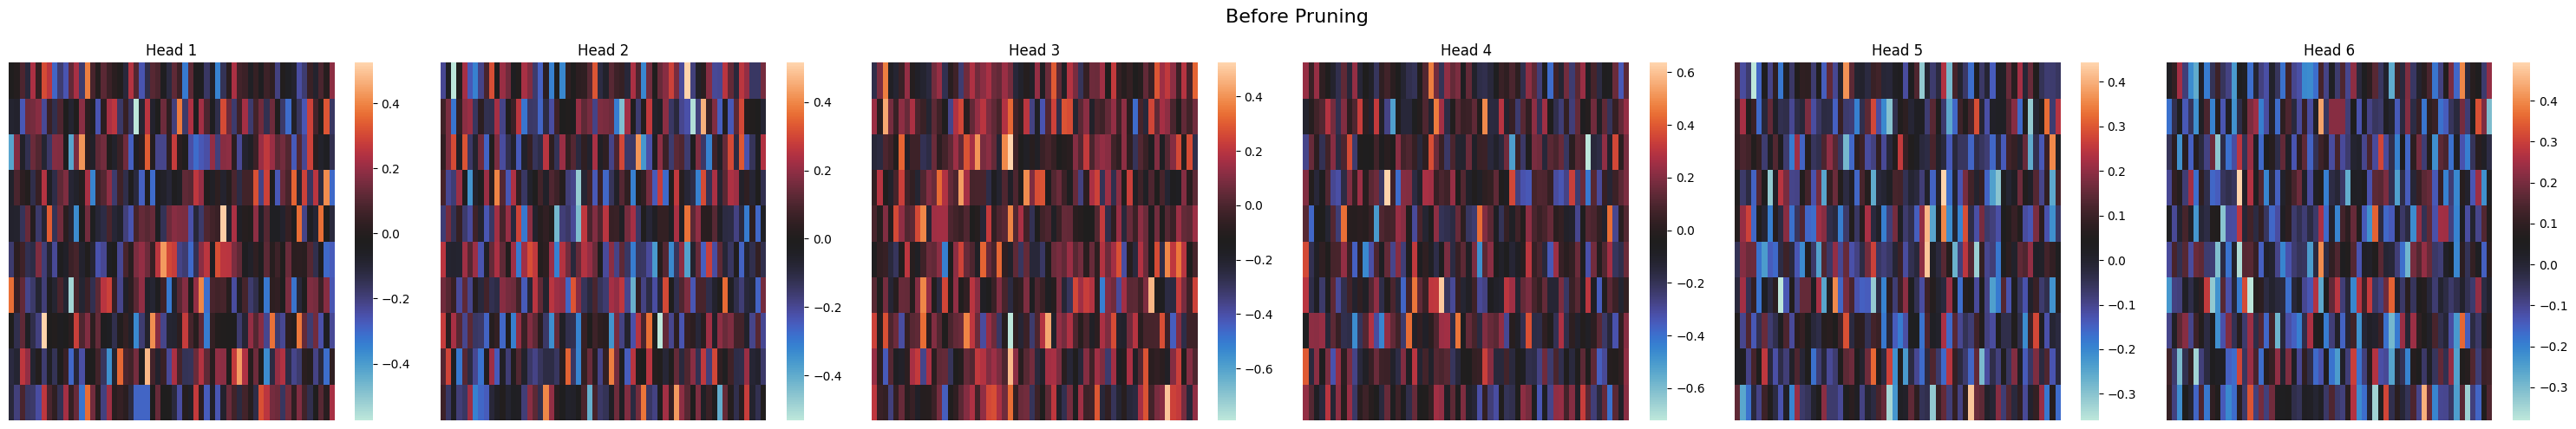

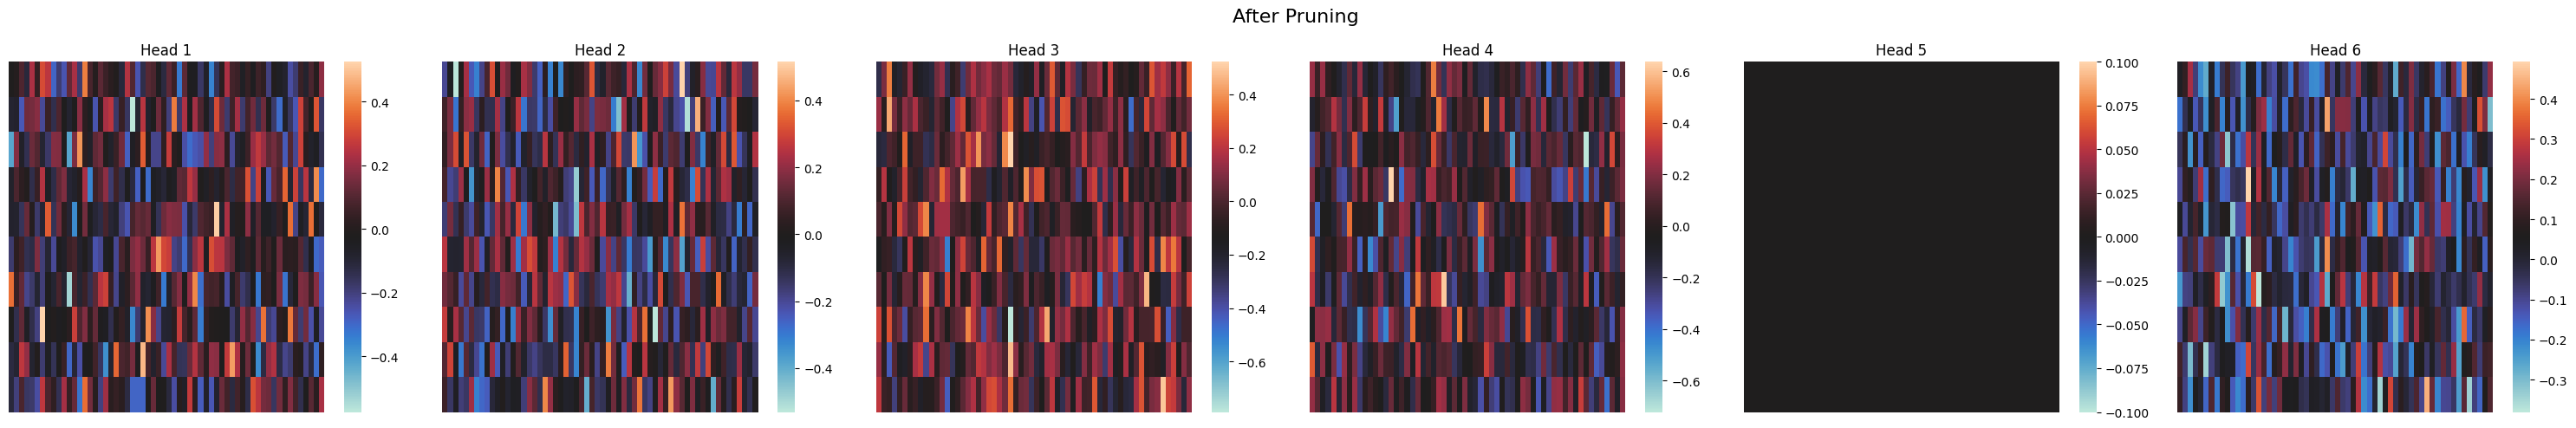

total params pruned: 43,200 across 24 layers
Overall sparsity: 0.1667
calculating model sparsity with 866,952 non-zero params out of 910,152 total params
model sparsity: 0.0475
sparse model size: 33.2164
------------------------------
pruning: 2 heads


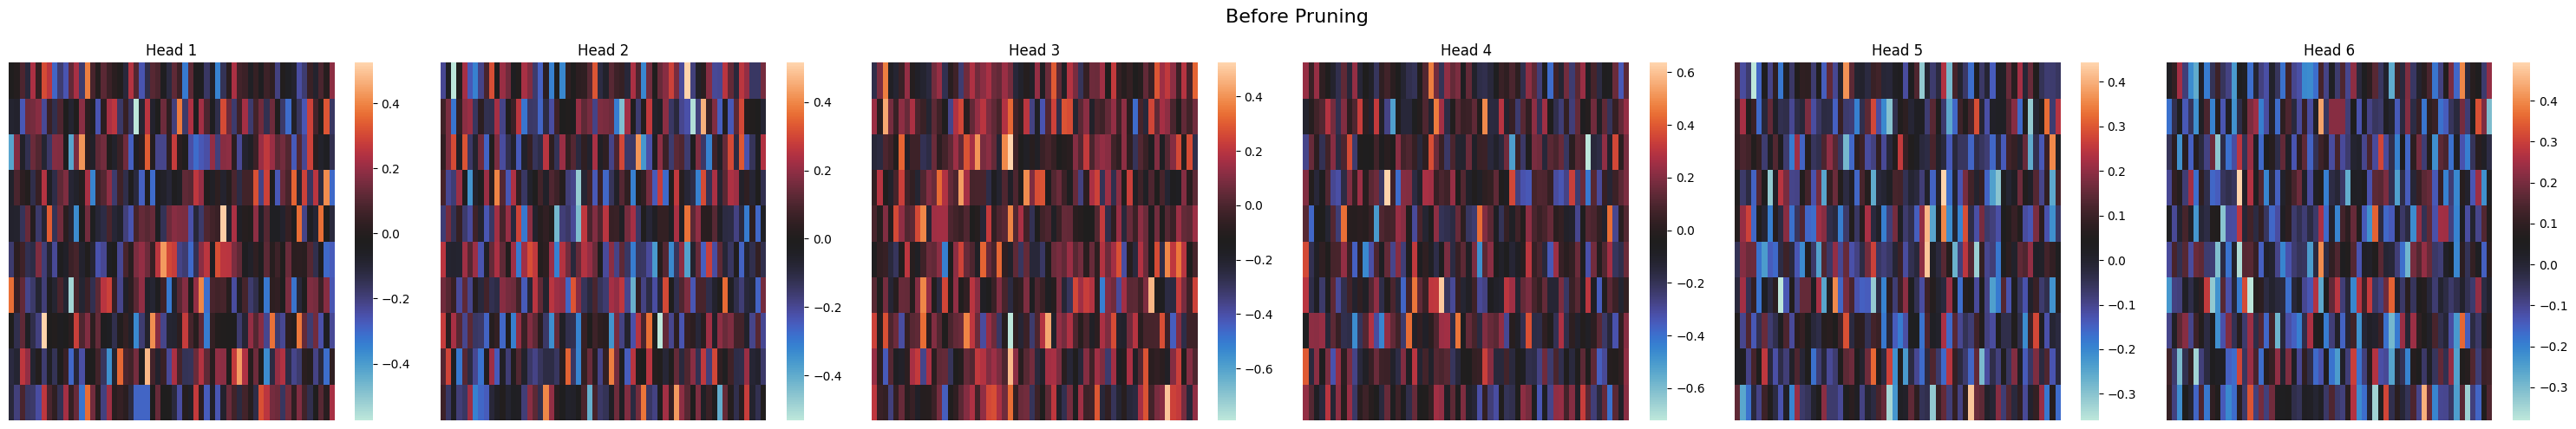

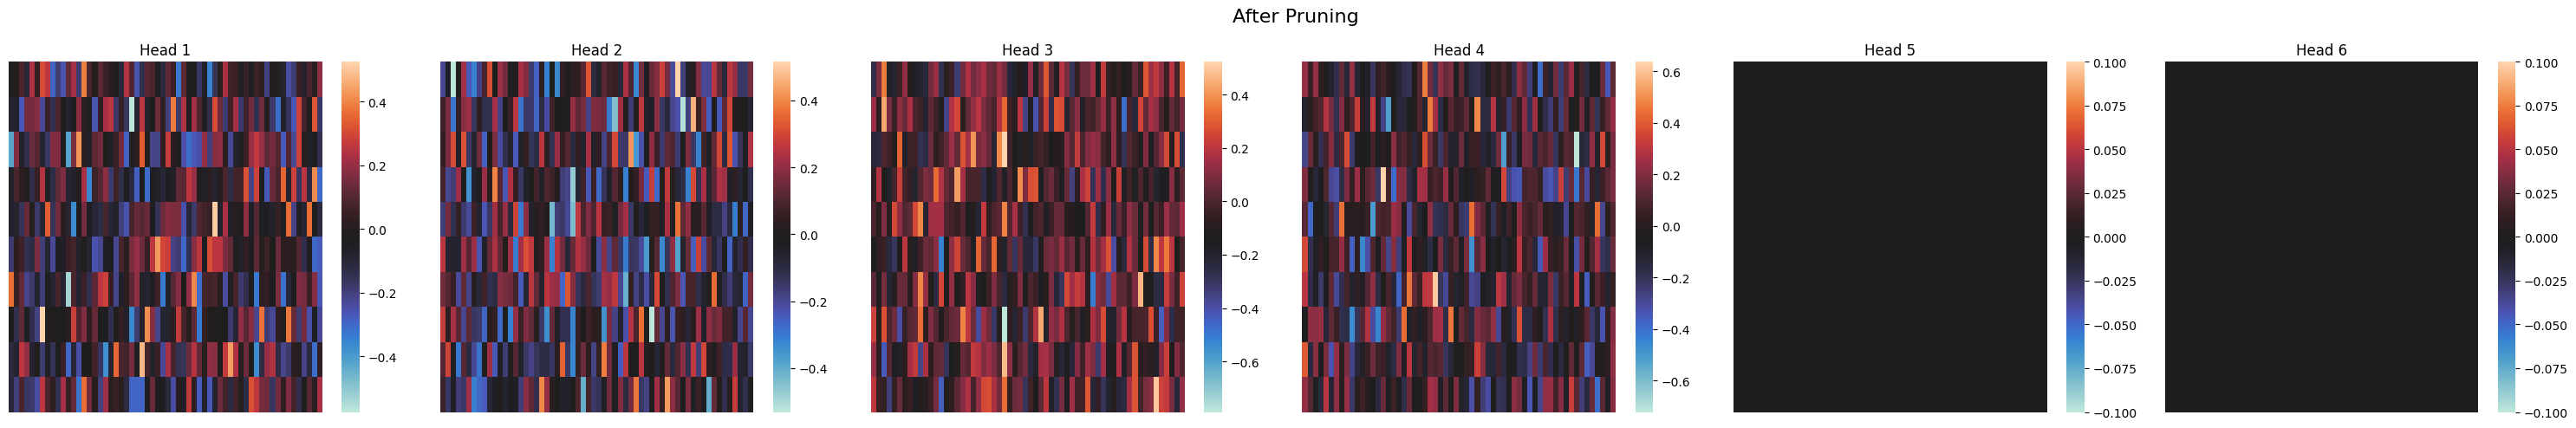

total params pruned: 86,400 across 24 layers
Overall sparsity: 0.3333
calculating model sparsity with 823,752 non-zero params out of 910,152 total params
model sparsity: 0.0949
sparse model size: 32.3531
------------------------------
pruning: 3 heads


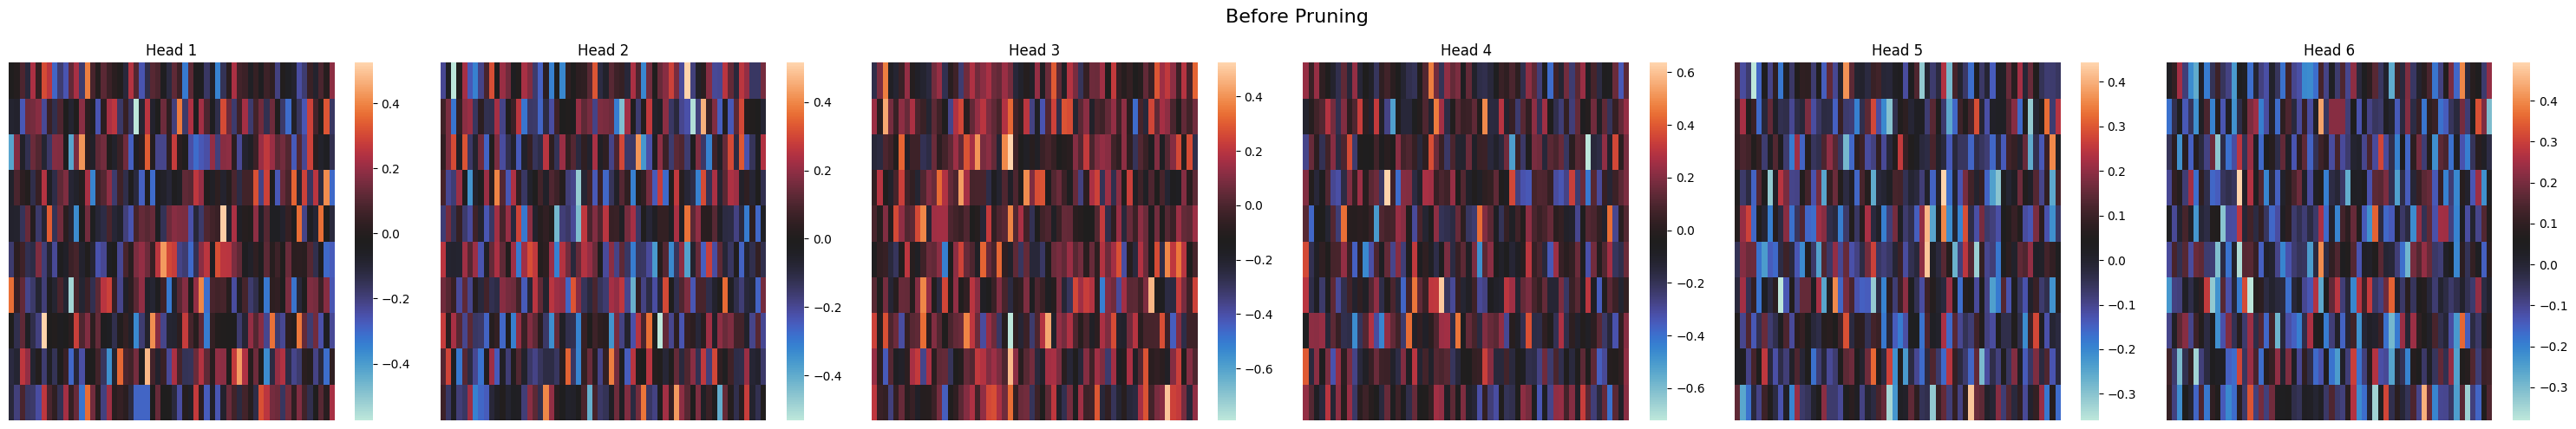

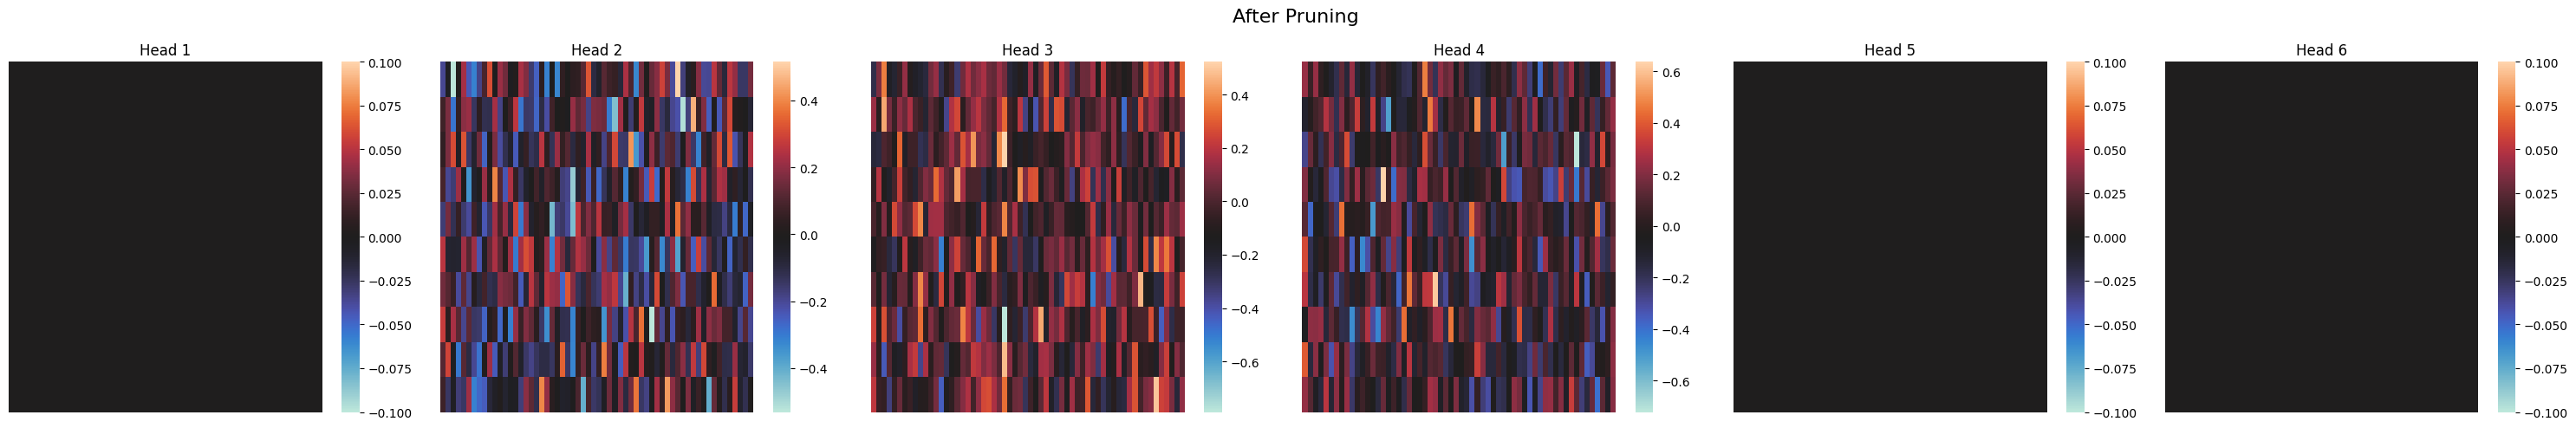

total params pruned: 129,600 across 24 layers
Overall sparsity: 0.5000
calculating model sparsity with 780,552 non-zero params out of 910,152 total params
model sparsity: 0.1424
sparse model size: 31.4884
------------------------------
pruning: 4 heads


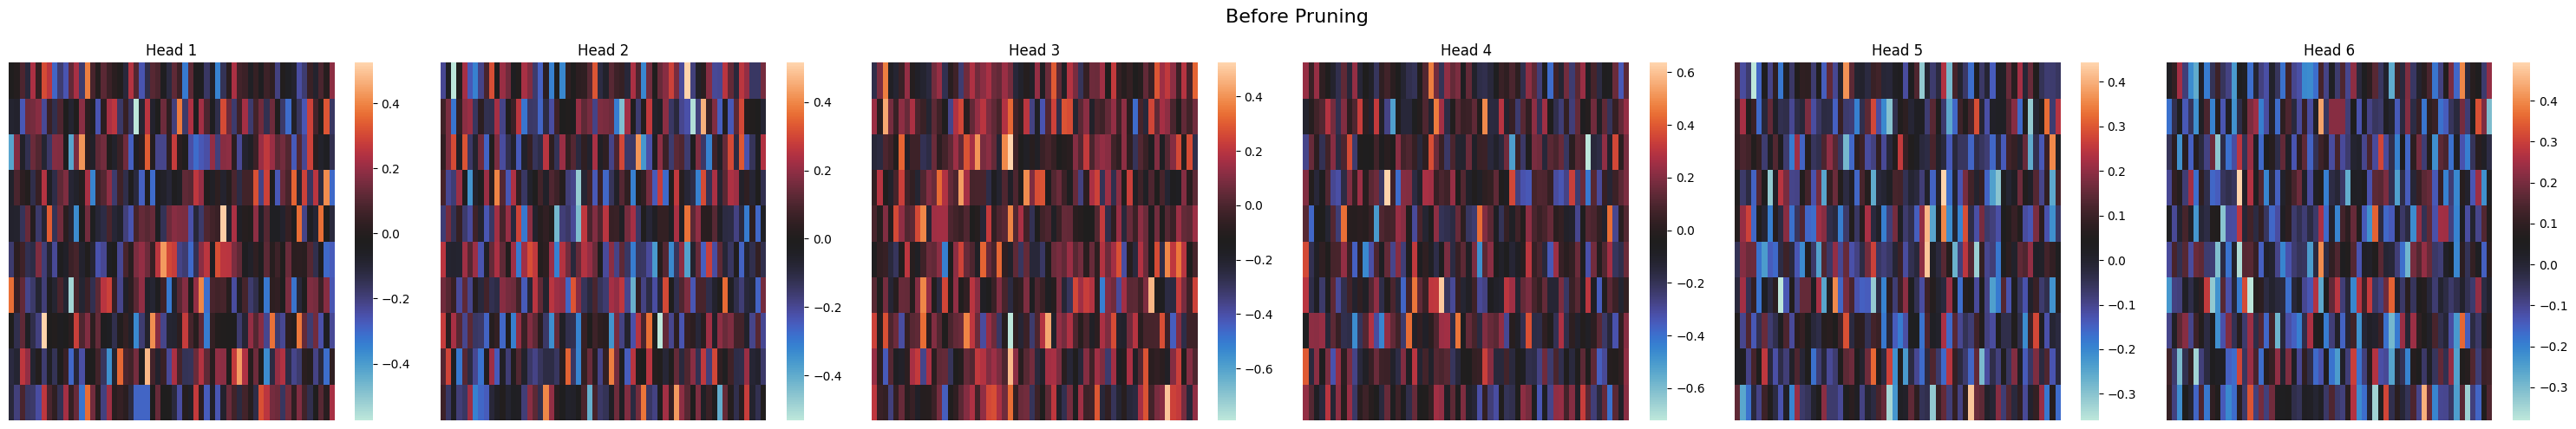

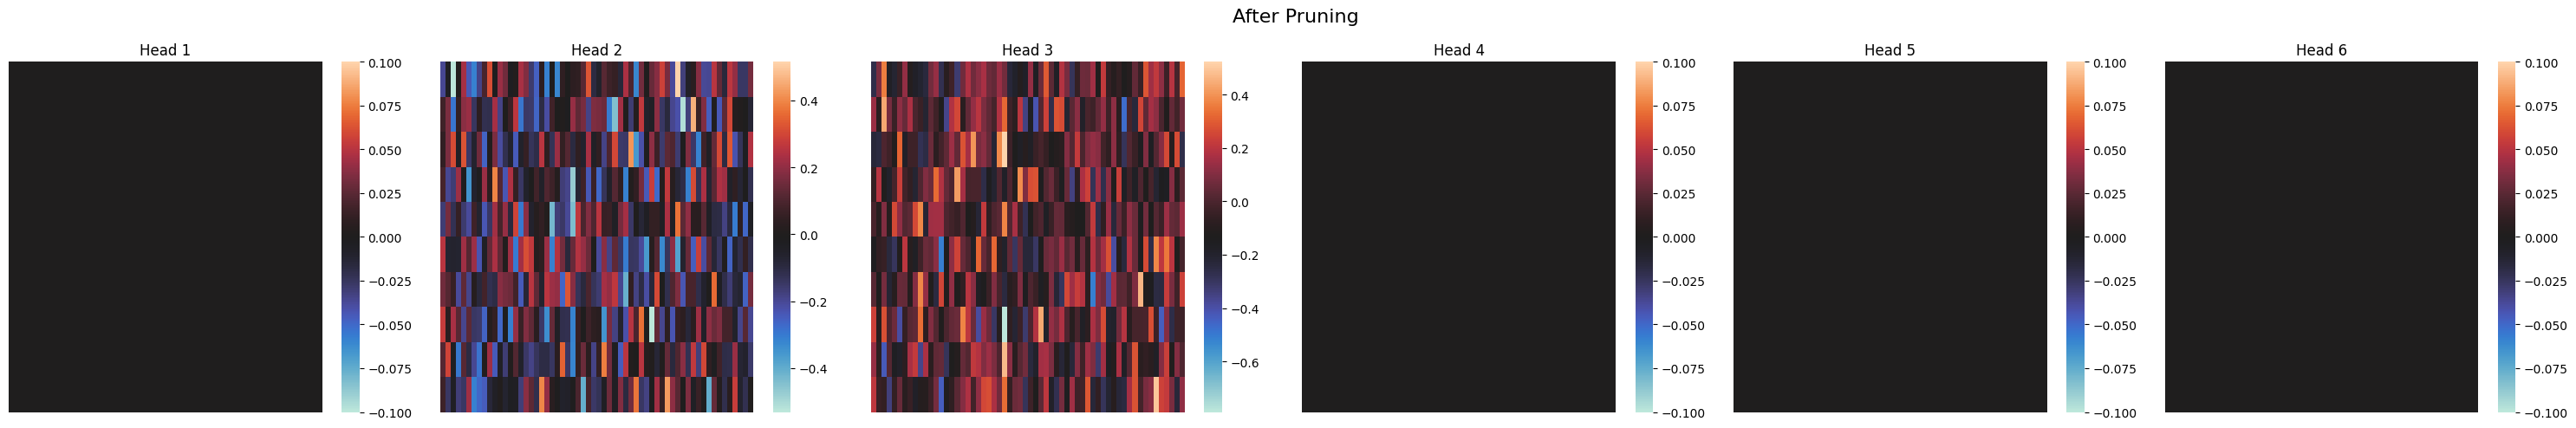

total params pruned: 172,800 across 24 layers
Overall sparsity: 0.6667
calculating model sparsity with 737,352 non-zero params out of 910,152 total params
model sparsity: 0.1899
sparse model size: 30.6251
------------------------------
pruning: 5 heads


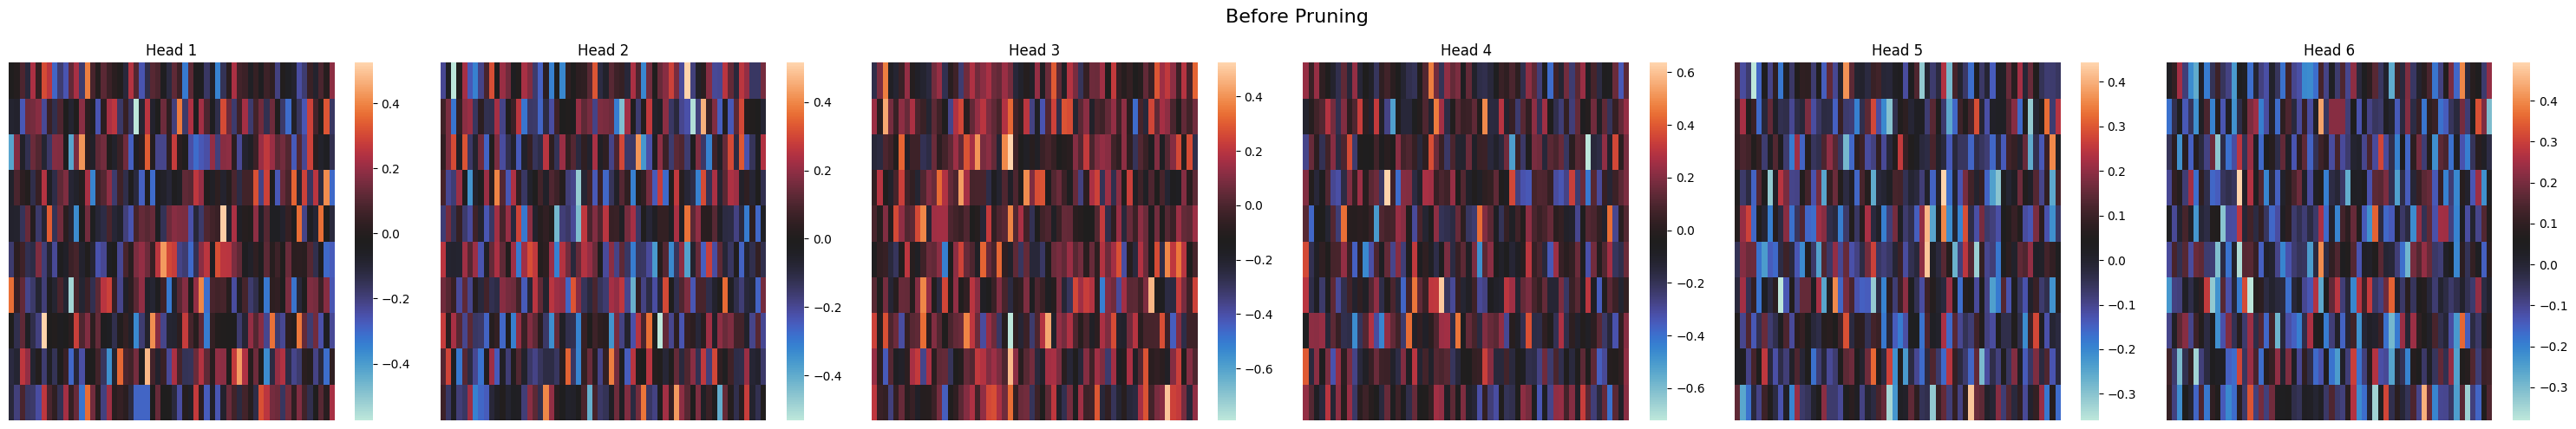

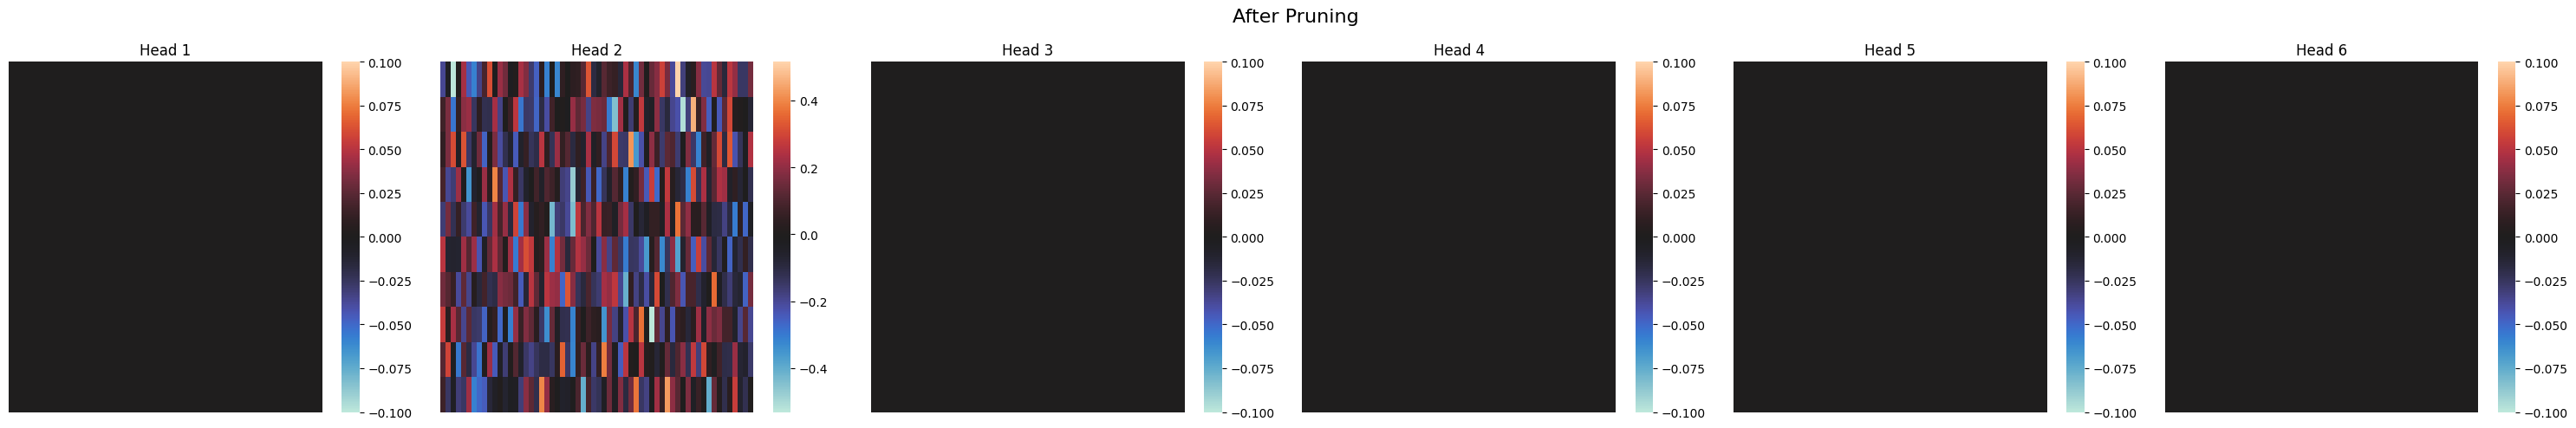

total params pruned: 216,000 across 24 layers
Overall sparsity: 0.8333
calculating model sparsity with 694,152 non-zero params out of 910,152 total params
model sparsity: 0.2373
sparse model size: 29.7604
------------------------------
pruning: 6 heads


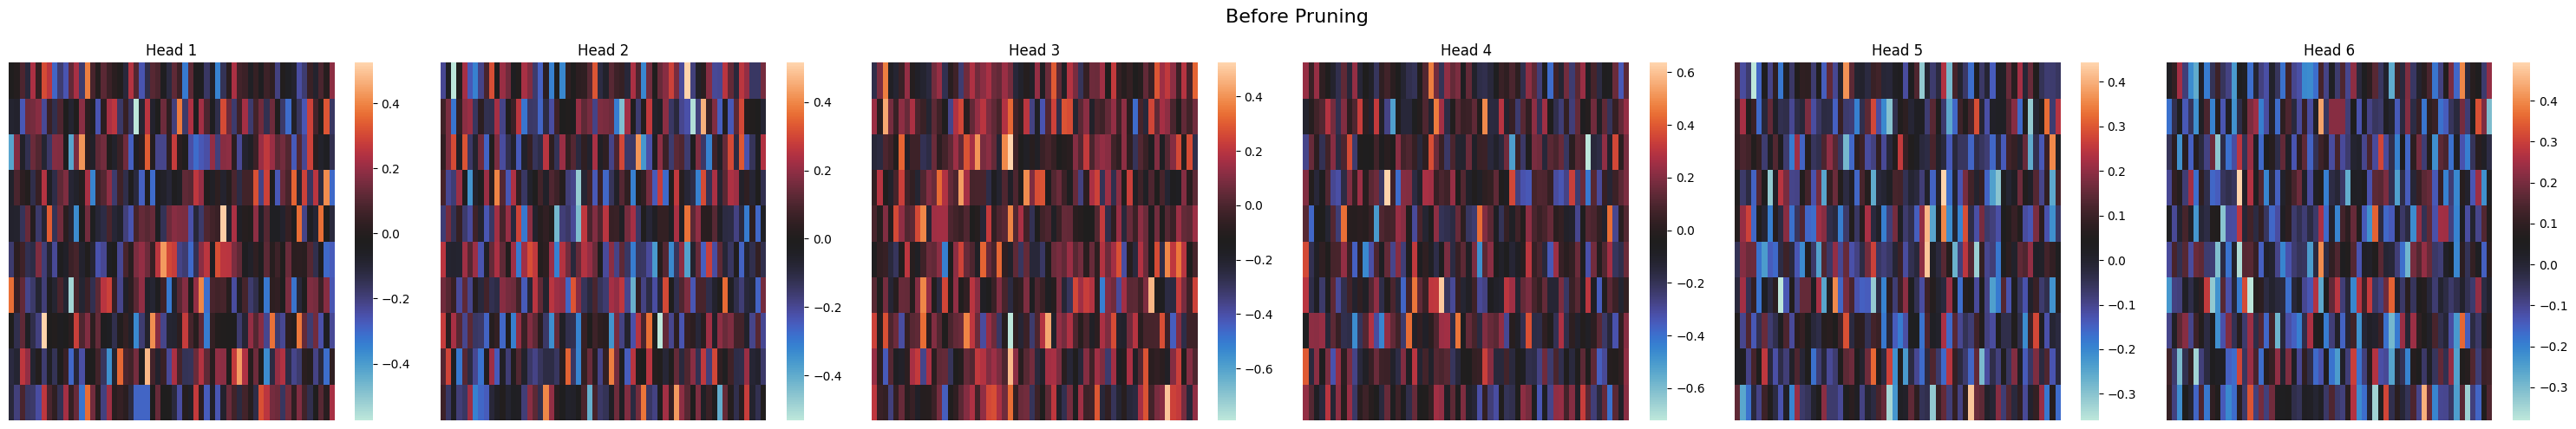

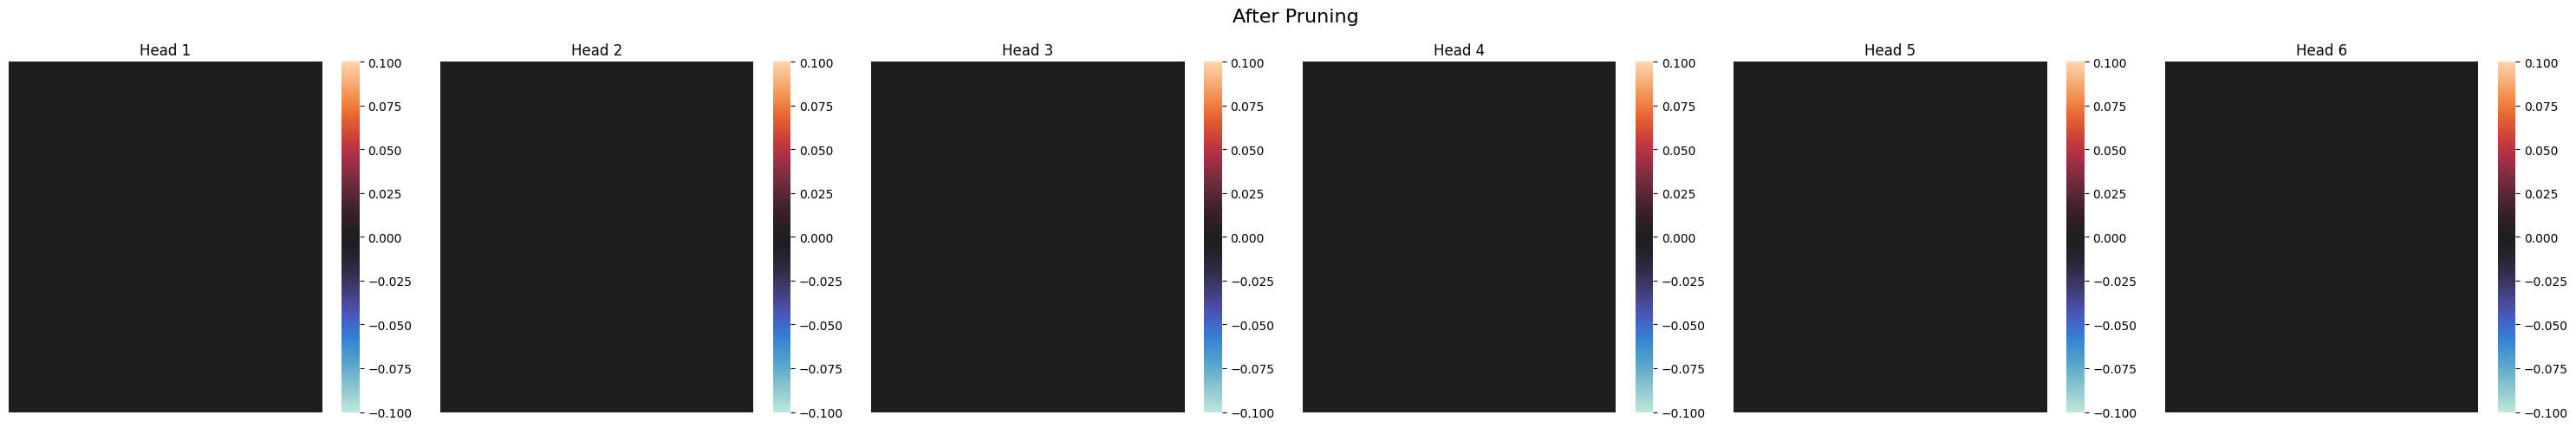

total params pruned: 259,200 across 24 layers
Overall sparsity: 1.0000
calculating model sparsity with 650,952 non-zero params out of 910,152 total params
model sparsity: 0.2848
sparse model size: 28.8970
------------------------------


In [178]:
importlib.reload(pu) #reloading the module to reflect changes in the file

for ph in range(7): # swinIR has 6 attention heads, so we are pruning 0 (none) to 6 (all) heads
    print(f"pruning: {ph} heads")
    mod2prune = copy.deepcopy(model)
    pu.prune_attn_heads(mod2prune, ph, 24) #pruning ph heads and plotting every few layers
    print("-"*30)


In [ ]:
pruning_data_structured_attn_heads = {
    "Heads Pruned" : [0, 1, 2, 3, 4, 5, 6],
    "Sparsity (Heads)" : [0.0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1.0],
    "Sparsity (Model)" : [0.0, 0.0475, 0.0949, 0.1424, 0.1899, 0.2373, 0.2848],
    "Accuracy" : [],
    "Latency (s)" : [],
    "Disk Size (MB)" : [34.07, 33.20, 32.34, 31.47, 30.61, 29.75, 28.88],

}

### Pruning Linear Layer Neurons
Each MLP module has **2 linear layers**:
  - **fc1**: `Linear(in_features=60, out_features=120, bias=True)`
  - **fc2**: `Linear(in_features=120, out_features=60, bias=True)`
  
Each linear layer has weights of shape `(out_features, in_features)`. We prune along `dim=1`, i.e., input features to a neuron.
  - For each input neuron pruned in `fc1`, we prune **120 parameters**.
  - For each input neuron pruned in `fc2`, we prune **60 parameters**.
  - Total parameters pruned per MLP module = `120 + 60 = 180 parameters per neuron`.

The model contains **24 MLP modules**.
Total parameters pruned per neuron across the model = `180 * 24 = 4,320 parameters per neuron`.

pruning: 0 neurons


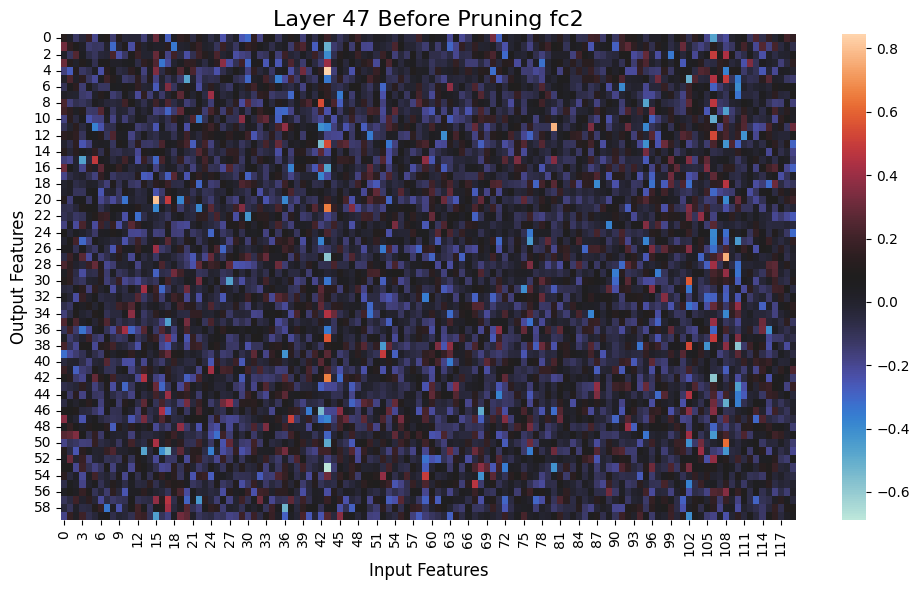

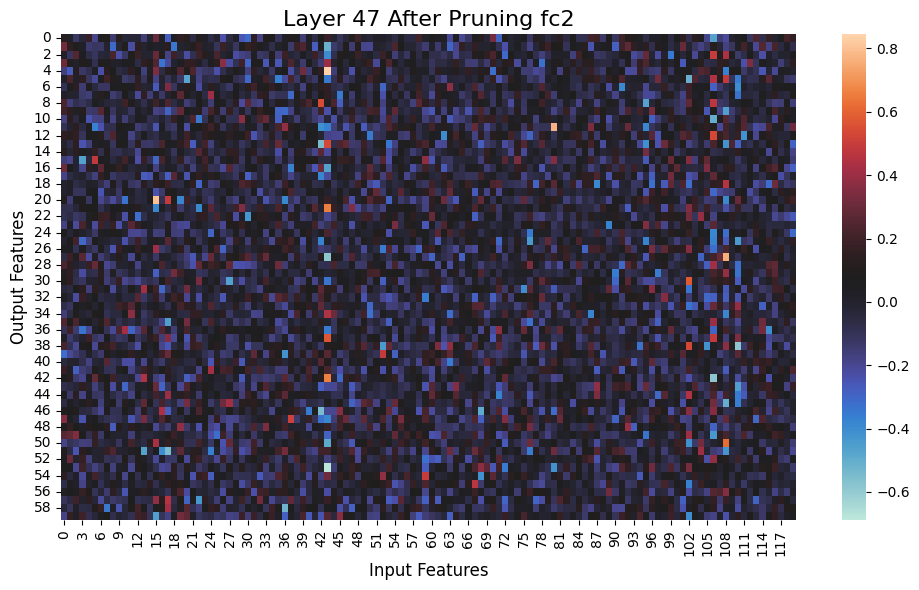

total params pruned: 0 across 48 layers
Overall sparsity: 0.0000
calculating model sparsity with 910,152 non-zero params out of 910,152 total params
model sparsity: 0.0000
sparse model size: 34.0811
------------------------------
pruning: 10 neurons


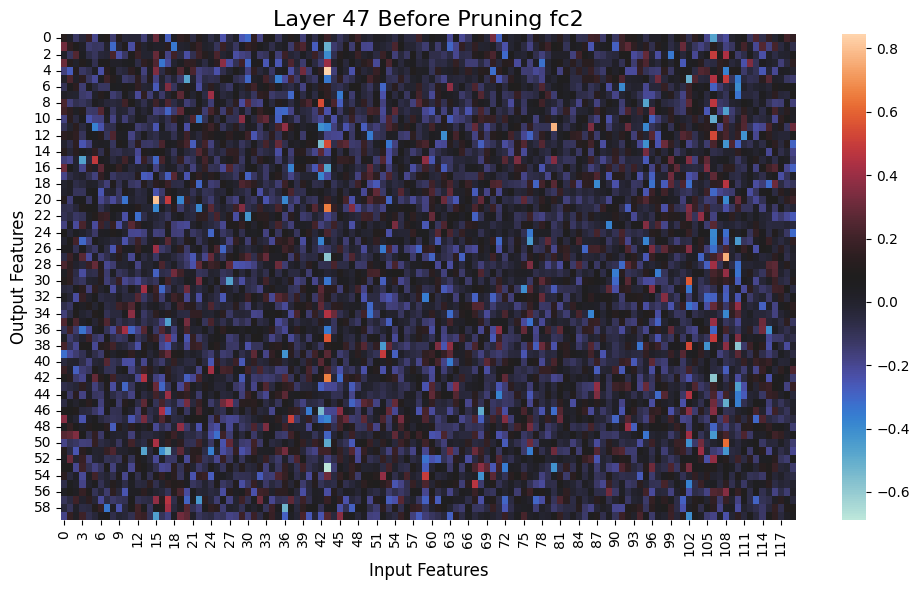

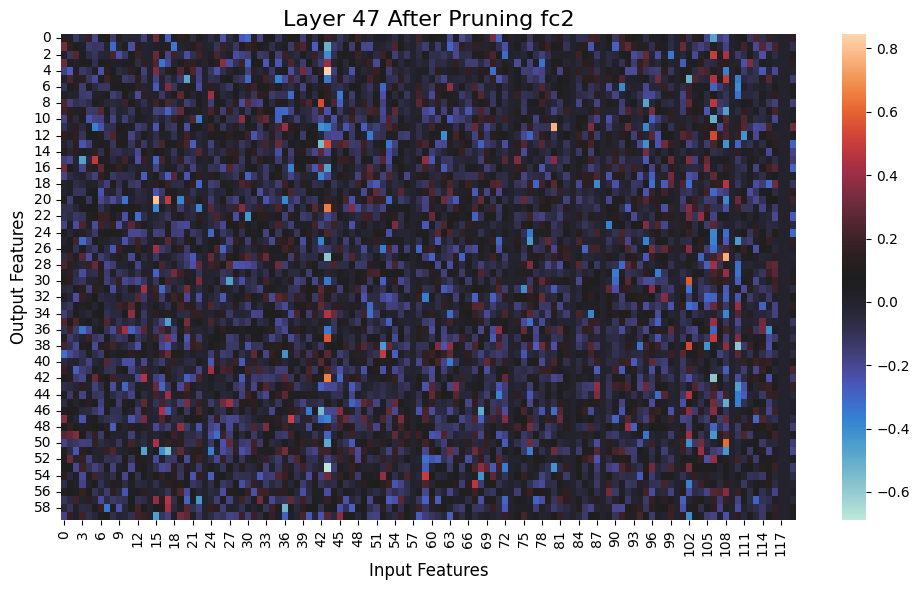

total params pruned: 43,200 across 48 layers
Overall sparsity: 0.1250
calculating model sparsity with 866,952 non-zero params out of 910,152 total params
model sparsity: 0.0475
sparse model size: 33.2172
------------------------------
pruning: 20 neurons


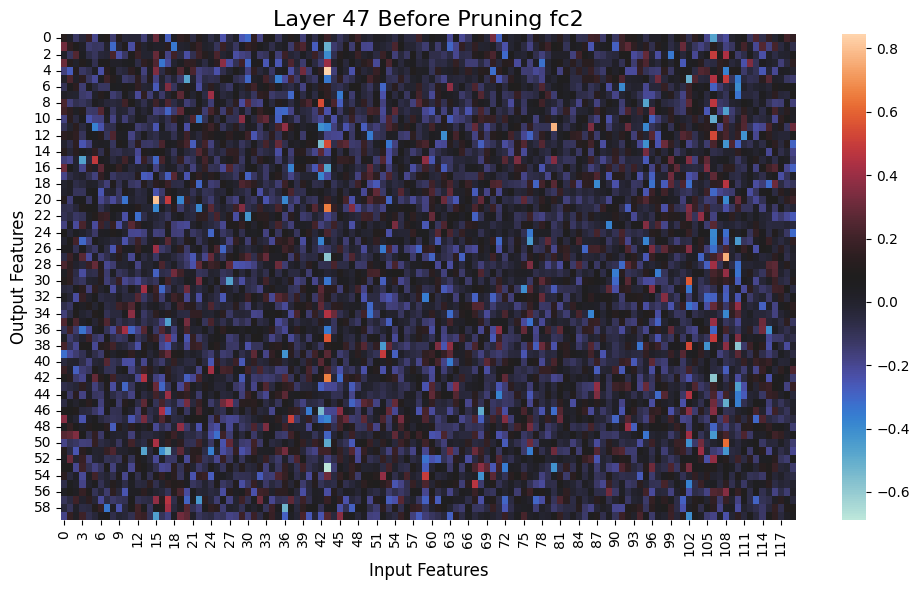

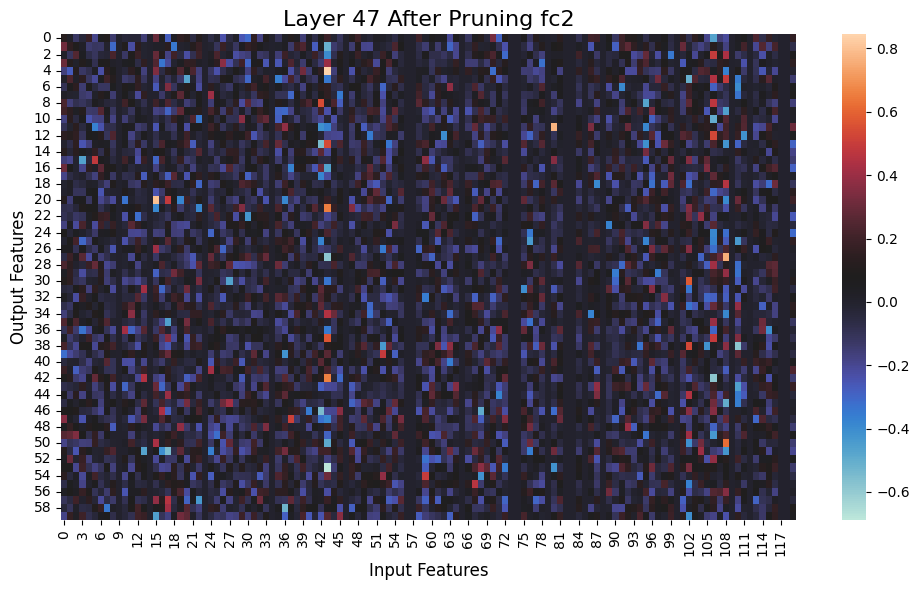

total params pruned: 86,400 across 48 layers
Overall sparsity: 0.2500
calculating model sparsity with 823,752 non-zero params out of 910,152 total params
model sparsity: 0.0949
sparse model size: 32.3540
------------------------------
pruning: 30 neurons


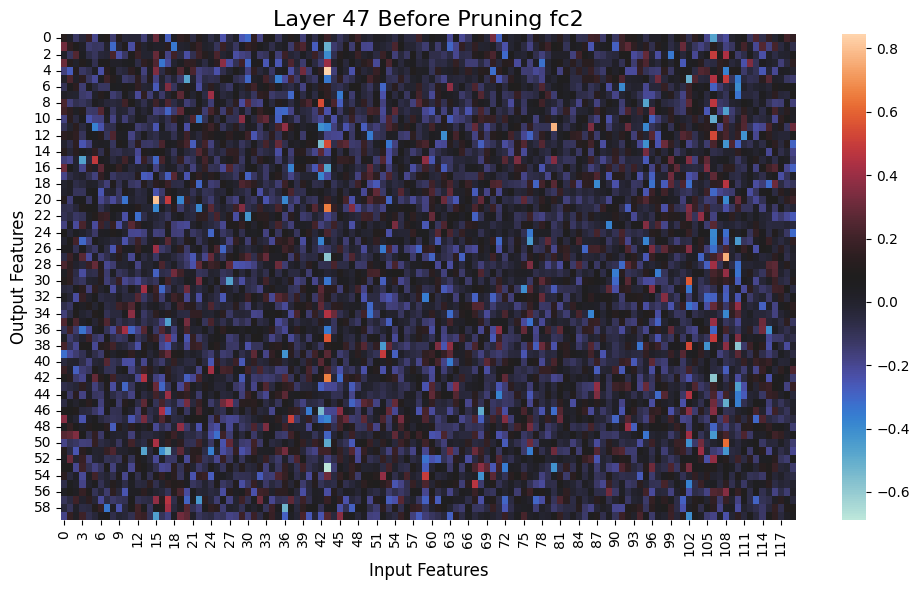

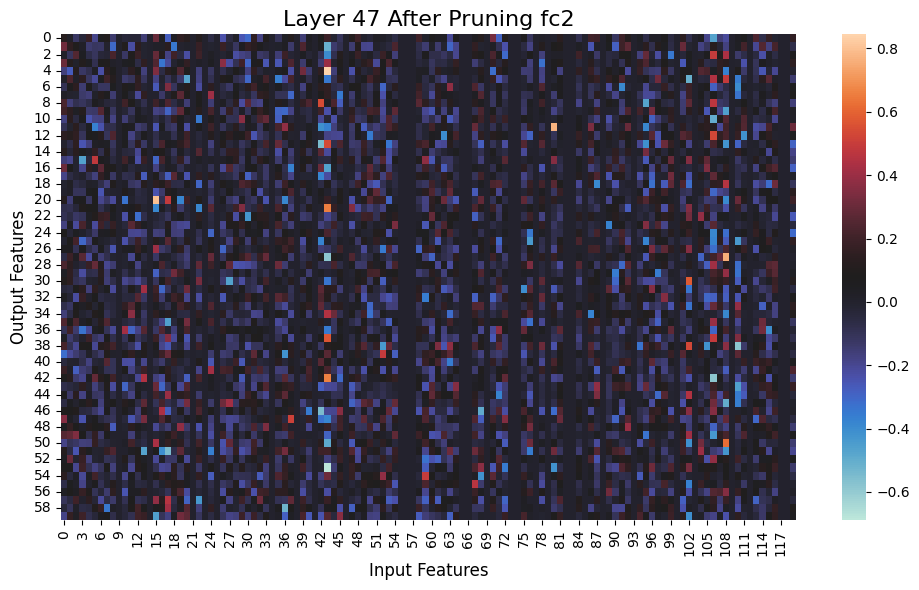

total params pruned: 129,600 across 48 layers
Overall sparsity: 0.3750
calculating model sparsity with 780,552 non-zero params out of 910,152 total params
model sparsity: 0.1424
sparse model size: 31.4892
------------------------------
pruning: 40 neurons


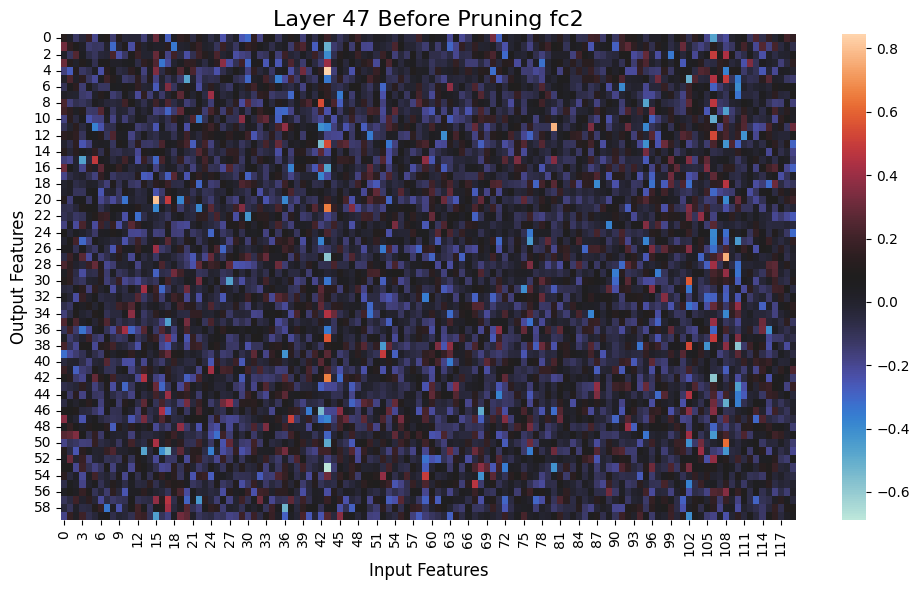

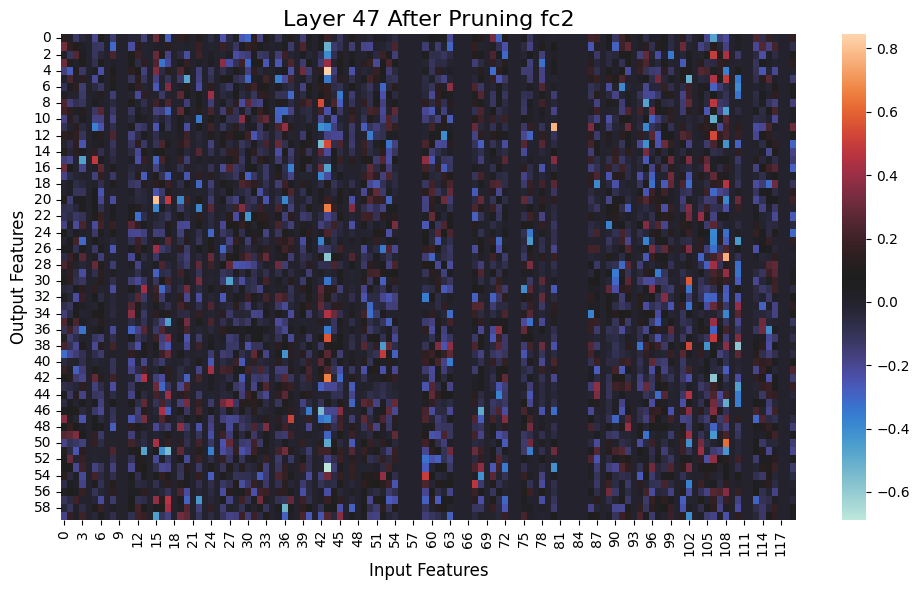

total params pruned: 172,800 across 48 layers
Overall sparsity: 0.5000
calculating model sparsity with 737,352 non-zero params out of 910,152 total params
model sparsity: 0.1899
sparse model size: 30.6260
------------------------------
pruning: 50 neurons


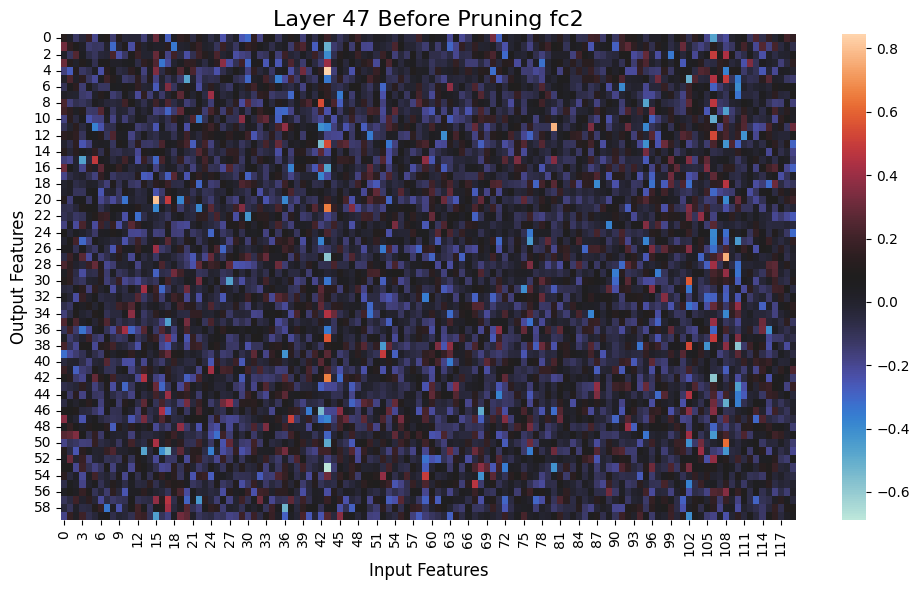

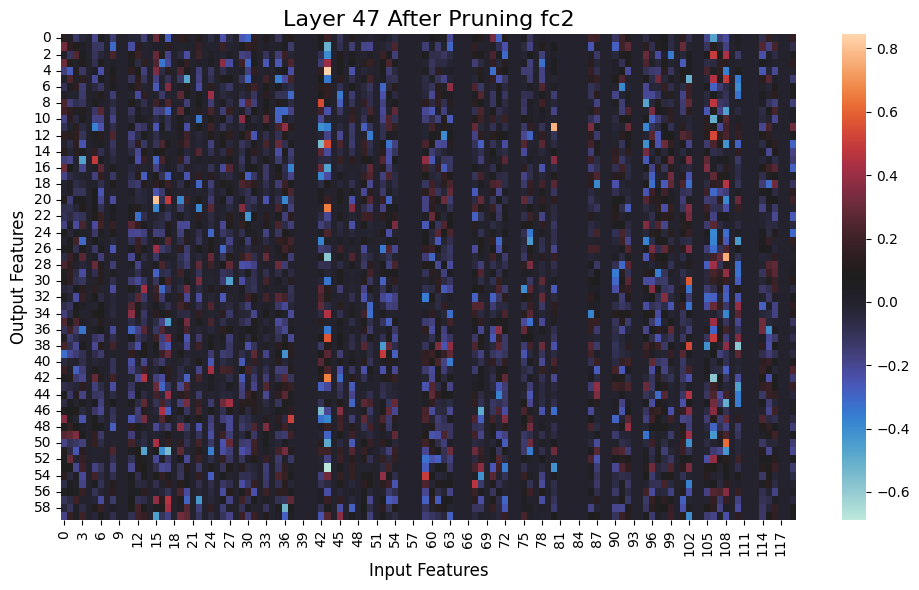

total params pruned: 216,000 across 48 layers
Overall sparsity: 0.6250
calculating model sparsity with 694,152 non-zero params out of 910,152 total params
model sparsity: 0.2373
sparse model size: 29.7612
------------------------------
pruning: 60 neurons


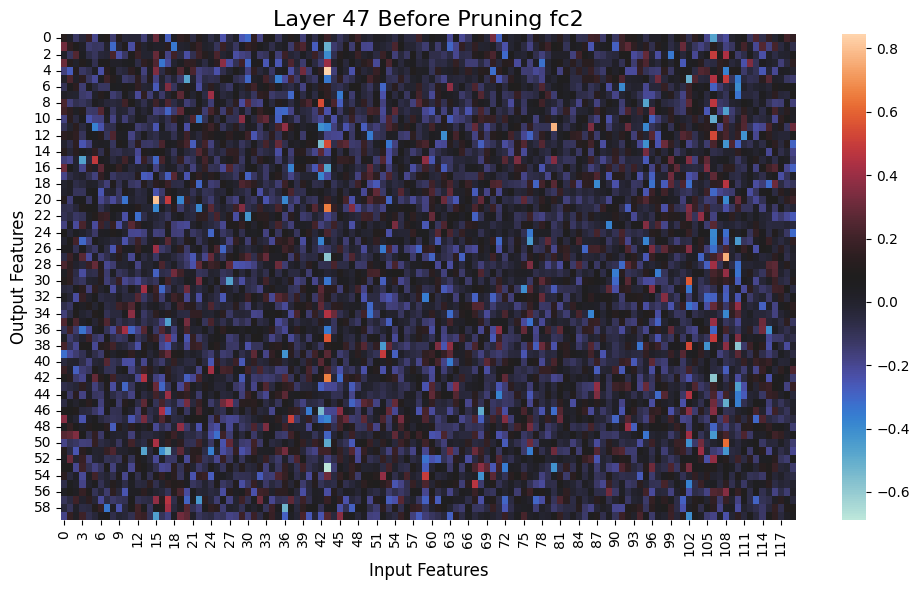

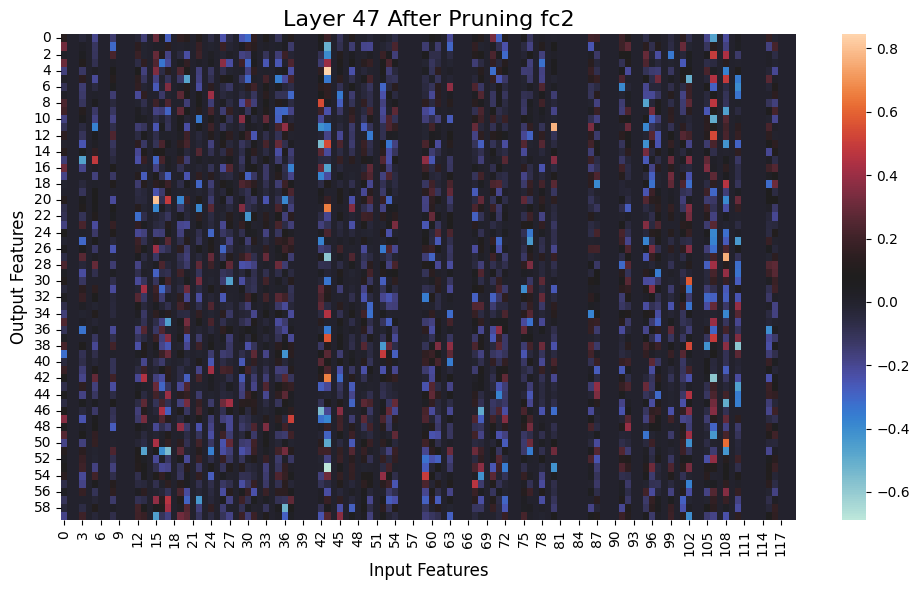

total params pruned: 259,200 across 48 layers
Overall sparsity: 0.7500
calculating model sparsity with 650,952 non-zero params out of 910,152 total params
model sparsity: 0.2848
sparse model size: 28.8979
------------------------------


In [179]:
importlib.reload(pu)

for pn in range(0, 61, 10):
    print(f"pruning: {pn} neurons")
    mod2prune = copy.deepcopy(model)
    pu.prune_linear_nodes(mod2prune, pn, 48)
    print("-"*30)


In [ ]:
pruning_data_structured_linear_nodes = {
    "Neurons Pruned" : [0, 10, 20, 30, 40, 50, 60],
    "Sparsity (Neurons)" : [0.0, 0.1250, 0.25, 0.3750, 0.5, 0.625, 0.75],
    "Sparsity (Model)" : [0.0, 0.0475, 0.0949, 0.1424, 0.1899, 0.2373, 0.2848],
    "Accuracy" : [],
    "Latency (s)" : [],
    "Disk Size (MB)" : [34.07, 33.22, 32.35, 31.49, 30.63, 29.76, 28.90],
}